
<font color='blue'> **12_Pinder-Sauer**  </font> ___ Sinusoidal inflow hydrograph boundary condition at the upstream end of the surface-water system.

In [31]:
import os ; import pathlib as pl ; import flopy ; import matplotlib.pyplot as plt ; import numpy as np; from pathlib import Path  
import pandas as pd ; from modflow_devtools.misc import get_env, timed ; write=get_env("WRITE", True);run=get_env("RUN", True)

In [32]:
sim_ws         = Path("./12_sfr-pindersauer")            ; sim_ws.mkdir(exist_ok=True) ; sim_name = "sfr-pindersauer"
exe_name       = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe' ; workspace = figs_path = sim_ws ; gwf_name = sim_name 
output_folder1 = Path(sim_ws/'ex-gwf-sfr-pindersauera')  ; output_folder2 = Path(sim_ws/'ex-gwf-sfr-pindersauerb')

path = 'E:\\15_REPOS\\00_BETAMI\\bin\\data_modflow6-examples\\ex-gwf-sfr-pindersauer'
aux_ws = Path("./_aux")
fpath1 = os.path.join(path,"delr.txt")            ; delr = np.loadtxt(fpath1, dtype=float)   ; np.savetxt(sim_ws / "aa1.csv", delr, delimiter=",")
fpath2 = os.path.join(path,"initial_head.txt")    ; strt = np.loadtxt(fpath2, dtype=float)   ; np.savetxt(sim_ws / "aa2.csv", strt, delimiter=",")
fpath3 = os.path.join(path,"initial_stage_a.txt") ; stage1 = np.loadtxt(fpath3, dtype=float) ; np.savetxt(sim_ws / "aa3.csv", stage1, delimiter=",")
fpath4 = os.path.join(path,"initial_stage_b.txt") ; stage2 = np.loadtxt(fpath4, dtype=float) ; np.savetxt(sim_ws / "aa4.csv", stage2, delimiter=",")

parameters = {"ex-gwf-sfr-pindersauera": {"lambda_val": (-4.779e-2, -0.3608), "leakance":      0.0},
              "ex-gwf-sfr-pindersauerb": {"lambda_val": (-0.1785,   -0.3409), "leakance": 1.42e-04}}   # 4 x

In [33]:
length_units = "meters" ; nlay = 1 ;nrow = 65    ;ncol = 15 ;delr = "varies" ;delc = 609.61 ; top = "varies" ; botm = 0 ;strt = "varies" 
k11 = 0.003048          ; time_units = "seconds" ; ss = 0.0000001 ;sy = 0.25 ;nreaches = 65 ; slope = 0.001  ; roughness = 0.03858   ; q_base = 509.7 
q_amplitude = 141.58    ;lambda1 = "varies"      ;  lambda2 = "varies" ;  Gamma = 4894.3    ; delr = np.loadtxt(fpath1, dtype=float) ; fr = 0.000349
nper = 1; nstp = 288    ; dt = 300.0; times = np.arange(0.0, 86400.0 + dt, dt)              ; tdis_ds = [(86400.0, nstp, 1.0)]   

shape2d = (nrow, ncol)  ; shape3d = (nlay, nrow, ncol)                         ; obs_loc = 24.0 * delc  ; obs_ifno = int(obs_loc / delc)
inflows = q_base + q_amplitude * np.sin(2.0 * np.pi * times / 18000.0)         ; ts_data = [(t, q) for t, q in zip(times, inflows)]

strt = np.loadtxt(fpath2, dtype=float)    
stage = np.loadtxt(fpath3, dtype=float)   ; parameters["ex-gwf-sfr-pindersauera"]["stage"] = [(ifno, float(stage1[ifno])) for ifno in range(nreaches)]
stage = np.loadtxt(fpath4, dtype=float)   ; parameters["ex-gwf-sfr-pindersauerb"]["stage"] = [(ifno, float(stage2[ifno])) for ifno in range(nreaches)]

upstream_frac = [0.0] + (nrow - 1) * [1.0] ; nconn = [1] + (nrow - 2) * [2] + [1]                          ; sfr_spd = {0: [(0, "inflow", "inflow")]}
sfr_conn = ([(0, -1)]+ [(idx, idx - 1, -(idx + 1)) for idx in range(1, nrow - 1)]+ [(nrow - 1, (nrow - 2))])

In [34]:
jcol_sfr = 7                   ; top = np.repeat(np.linspace(8.675181e01, 4.773705e01, nrow).reshape(nrow, 1), ncol, axis=1)
top[:, jcol_sfr] = np.linspace(6.065575e01, 2.164100e01, nrow)      ; np.savetxt(sim_ws  / "a1_top.csv", top, delimiter=",") 
leakance2=1.42e-04
pak_data2 = [(ifno,0,ifno,jcol_sfr,delc,delr[jcol_sfr],slope,top[ifno, jcol_sfr],1.0,leakance2,roughness,nconn[ifno],
             upstream_frac[ifno],0,) for ifno in range(nreaches)]   ; np.savetxt(sim_ws / "a2_pak_data2.csv", pak_data2, delimiter=",") 

In [ ]:
def build_models(sim_name, lambda_val, leakance, stage):
    name = sim_name.replace("pindersauer", "ps")
    pak_data = [(ifno,0,ifno,jcol_sfr,delc,delr[jcol_sfr],slope,top[ifno, jcol_sfr],1.0,leakance,roughness,nconn[ifno],
                 upstream_frac[ifno],0,) for ifno in range(nreaches)]                                   ;  fname = f"{name}.sfr.obs"
    sfr_obs = {f"{fname}.csv": [("inflow-ext", "ext-inflow", (0,)),("inflow", "inflow", (obs_ifno,)),
                                ("outflow", "outflow", (obs_ifno,)),("stage", "stage", (obs_ifno,)),("depth", "depth", (obs_ifno))]}
    
    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation   (sim_name=name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis   (sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms    (sim)
    gwf = flopy.mf6.ModflowGwf     (sim, modelname=name)
    flopy.mf6.ModflowGwfdis (gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm)
    flopy.mf6.ModflowGwfnpf (gwf,icelltype=1,k=k11)
    flopy.mf6.ModflowGwfsto (gwf,iconvert=1,sy=sy,ss=ss,transient={0: True})
    flopy.mf6.ModflowGwfic  (gwf, strt=strt)
    flopy.mf6.ModflowGwfoc   (gwf, printrecord=[("budget", "all")])
    sfr = flopy.mf6.ModflowGwfsfr (gwf,print_input=True,print_flows=True,storage=True,nreaches=nreaches,packagedata=pak_data,
                                   connectiondata=sfr_conn,initialstages=stage,perioddata=sfr_spd,pname="sfr-1")
    sfr.ts.initialize  (filename=f"{name}.sfr.ts",timeseries=ts_data,time_series_namerecord=["inflow"],interpolation_methodrecord=["linearend"])
    sfr.obs.initialize (filename=fname, print_input=True, continuous=sfr_obs)
    return sim
def write_models(sim, silent=True): sim.write_simulation(silent=silent)
def run_models(sim, silent=True):   success, buff = sim.run_simulation(silent=silent)  ; assert success, buff
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]  ; params = parameters[key].copy() ; sim = build_models(key, **params)
    if write: write_models (sim, silent=silent)   
    if run:   run_models   (sim, silent=silent)
scenario(0)  ; scenario(1)  # Run without leakage. / # Run with leakage.

In [36]:
key = list(parameters.keys()); key

['ex-gwf-sfr-pindersauera', 'ex-gwf-sfr-pindersauerb']

In [37]:
sim1 = flopy.mf6.MFSimulation.load(sim_ws = output_folder1    ,exe_name=exe_name,  verbosity_level=0)
obs1 = sim1.get_model().sfr.output.obs().get_data()           ;  obs1["totim"] /= 3600.0; pd.DataFrame(obs1) ; 
sim2 = flopy.mf6.MFSimulation.load(sim_ws = output_folder2    ,exe_name=exe_name,  verbosity_level=0)
obs2 = sim2.get_model().sfr.output.obs().get_data()           ;  obs2["totim"] /= 3600.0; pd.DataFrame(obs2) ; obs2; 

**no leakage / leakage _ MODFLOW _ Stage(m)**

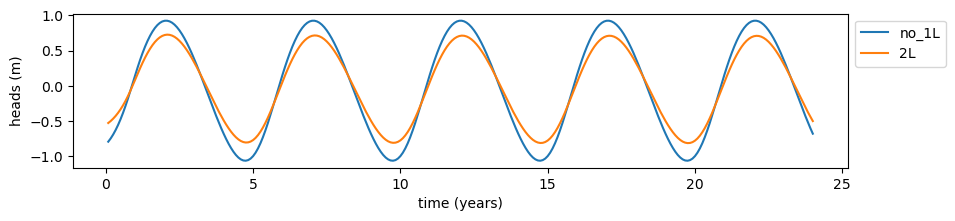

In [38]:
b1 = obs1["DEPTH"] ; bb1 = b1 - b1.mean()  ; df1 = pd.DataFrame(bb1,columns=['no_1L']) ; df0 = pd.DataFrame(obs1['totim'],columns=['totim']) 
b2 = obs2["DEPTH"] ; bb2 = b2 - b2.mean()  ; df2 = pd.DataFrame(bb2,columns=['2L'])    ; df3 = pd.concat([df0,df1, df2], axis = 1) ; df3; 
ax = df3.plot(x="totim", y= ['no_1L','2L'] , kind="line", figsize=(10,2))  
ax.legend(bbox_to_anchor=(1.0, 1.0)); ax.set(xlabel="time (years)", ylabel="heads (m)"); plt.show()

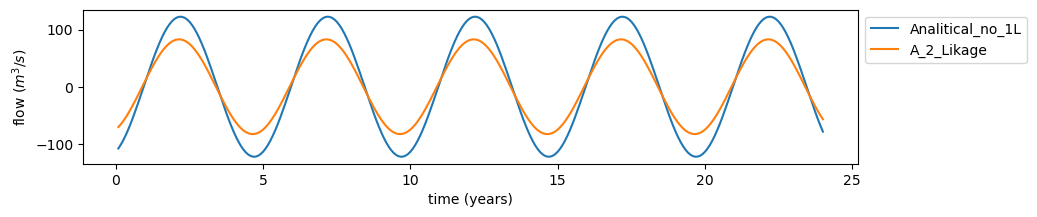

In [39]:
def analytical_solution(lambdas, x, t):    return q_base + q_amplitude * np.exp(lambdas[0] * x / Gamma) * np.sin(fr * t + lambdas[1] * x / Gamma)
list(parameters.values())                ; analytical = []
for key, value in parameters.items():      lambda_val = value["lambda_val"]      ; analytical.append(analytical_solution(lambda_val,obs_loc,times)-q_base)
df = pd.DataFrame(analytical).T          ; df.columns = ["Analitical_no_1L", "A_2_Likage"]           ; df.to_csv (sim_ws/"aa5.csv")

df4 = pd.concat([df0,df], axis = 1)      ; df4.drop(df.tail(1).index,inplace=True) 
ax = df4.plot(x="totim", y= ["Analitical_no_1L", "A_2_Likage"]  , kind="line", figsize=(10,2))  
ax.legend(bbox_to_anchor=(1.0, 1.0)); ax.set(xlabel="time (years)", ylabel="flow ($m^3/s$)"); plt.show()